# Testando implementação básica do k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans). Código disponível na função `kMeansCPU`, localizada no arquivo `kMeans.py`.

## Imports e Variáveis Globais

In [59]:
import numpy as np
import pandas as pd

# from kMeans import *
import kMeans as km

import importlib
importlib.reload(km)



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 5

K = 3
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [12]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])

dataset

,d0,d1,d2,d3,d4
0,6.161810,9.900994,7.624701,6.665798,5.219063
1,8.540155,7.989304,8.723180,3.947086,2.312699
2,2.755176,9.570651,5.373282,1.864536,9.206934
3,7.925157,2.929571,6.475348,5.878871,8.593106
4,7.854338,2.815660,2.829809,6.186853,8.357341
...,...,...,...,...,...
99995,5.758308,1.431619,6.438242,9.855744,5.837308
99996,4.346099,7.501241,6.047777,6.312001,7.603106
99997,9.031893,7.529281,2.224744,9.924683,1.497123
99998,1.108636,7.733650,1.944420,7.986901,3.015246


## K-Means (CPU)

In [13]:
result = km.kMeansCPU(dataset, K, MAX_ITERATIONS)

result

Iteration #2/500



0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Length: 100000, dtype: int64

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [14]:
# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
km.downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [15]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# // # Sobrescrevendo a coluna do dataset pelos indexes obtidos
# // dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Ignorando a coluna "class"
datasetTreated:pd.DataFrame = dataset.drop(['class'], axis=1)
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid  petalLen  petalWid
0        3.00     6.625  1.610169     1.375
1        2.50     4.750  1.610169     1.375
2        2.00     5.500  1.457627     1

## Rodando o K-Means

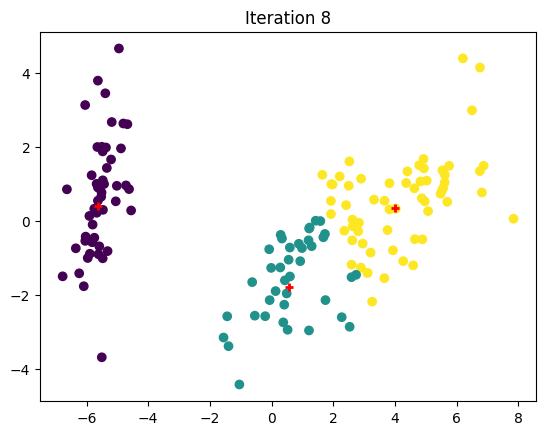

Iteration #8/500

Centroids:
   sepalLen  sepalWid  petalLen  petalWid
0  2.613660  6.143529  1.686990  1.494296
1  4.406264  3.218262  5.776541  5.361460
2  6.653880  4.714525  7.627264  7.778481

Distances:
             0         1          2
0     0.633408  6.843534   9.706222
1     1.405338  6.263432   9.719361
2     0.926038  6.748430  10.067004
3     1.342861  6.534070   9.980685
4     0.878785  7.091915   9.882999
..         ...       ...        ...
145  10.679365  5.181902   1.528083
146   9.518584  3.181035   2.021990
147   9.681312  4.126110   0.440030
148  10.310093  5.464731   2.312403
149   8.556487  2.989427   1.743136

[150 rows x 3 columns]

Closest centroid index:
0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64



In [61]:
results = km.kMeansCPU(datasetTreated, K, MAX_ITERATIONS, printIter=True, plotResults=True, debug=True)

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.

Essa comparação, no entanto, não é tão simplória de se realizar. Não há como sabermos qual o mapeamento correto entre a classificação feita pelo k-means e as classes reais das instâncias do dataset. Isto é, não há como discernir se o `1` na coluna de classificação de centróides se refere a uma identificação de uma `Iris-versicolor` ao invés de uma `Iris-virginica`, por exemplo.

Por isso, temos que realizar o **maximum matching** atingido pelo resultado do k-means, para realizar uma avaliação justa de seu desempenho.

### Maximum Matching

Teremos que avaliar todas as possibilidades de *mapeamento centróide–classe* e considerar apenas aquela que gera o melhor resultado.

Para isso, é necessário calcular os acertos do resultado diversas vezes. Como há $ k! $ maneiras de se interpretar `K` centróides, isto irá gerar um **custo computacional de $ n \cdot k! $ operações de comparação** entre classificações.

Podemos reduzir este tempo de computação salvando e reaproveitando inteligentemente a quantidade de acertos de classificação computados para cada *mapeamento centróide–classe*.

Por exemplo, há **duas** interpretações dos `K` centróides que possuem um mapeamento `0 -> Iris-Setosa`. São eles: `[Iris-setosa, Iris-versicolor, Iris-virginica]` e `[Iris-setosa, Iris-virginica, Iris-versicolor]`. Ao contar os acertos da primeira destas permutações dos `K` centróides, vamos obter os acertos de linhas do resultado do k-means onde o centróide mais próximo é o de index `0`, e cuja interpreção atual é de este `0` indicar uma flor `Iris-Setosa`. Como iremos usar essa mesma interpretação para centróides de index `0` na próxima permutação, podemos pular essa contagem redundante utilizando o resultado obtido na contagem anterior.

Utilizando este método, conseguimos **reduzir o custo de computação** de acertos de classificação **para $ n^2 $ operações de comparação**!

In [62]:
from itertools import permutations

print(f'result:\n{results}\n')
print(f'dataset:\n{dataset}\n')
print(f'classes:\n{classes}\n')

hits, hitsPerClass, centroidClasses = km.getClassificationHits(results, dataset, classes=classes, debug=DEBUG)

if DEBUG: print(f'Hits: {hits}\nHits per class: {hitsPerClass}\nCentroid classes: {centroidClasses}\n')

result:
0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64

dataset:
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]

classes:
['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

#################### Computing classification hit

### Resultados

Rodando a função **`getClassificationHits()`** nos resultados do k-means, encontramos resultados bem esperados:

- Acertos totais entre **130–140**, de 150 classificações (**86,66–93,33%** de acerto)
- Acertos por classe:
  - `Iris-setosa`: quase sempre **50** de 50 (**100%**)
  - `Iris-versicolor`: **35–38** de 50 (**70–76%**)
  - `Iris-virginica`: **45–48** de 50 (**90–96%**)

Estes resultados são exatamente o que esperamos do dataset **Iris**, já que nele temos uma classe linearmente separável (`Iris-setosa`) e duas que NÃO são linearmente separáveis uma da outra (`Iris-versicolor` e `Iris-virginica`).